### Information Retrieval Coursework (STW7071CEM)

Task: Develop a document clustering system.

First, collect a number of documents that belong to different categories, namely Sport, Health and Business. Each document should be at least one sentence (the longer is usually the better). The total number of documents is up to you but should be at least 100 (the more is usually the better).

Once you have collected sufficient documents, cluster them using a standard clustering method (e.g. K-means).

Finally, use the created model to assign a new document to one of the existing clusters. That is, the user enters a document (e.g. a sentence) and your system outputs the right cluster.

### Importing Modules

In [1]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
from scipy import interp


# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

### Load Dataset

In [2]:
df = pd.read_csv('news-dataset.csv',encoding='latin1')
df = df[df['category'].isin(['HEALTH','SPORTS','BUSINESS'])]
print(df.shape)
df.head()


(15000, 5)


,category,headline,links,news,keywords
0,HEALTH,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,HEALTH,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,HEALTH,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,HEALTH,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,HEALTH,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [3]:
df.drop(columns=['headline'], inplace=True)
df.head()

,category,links,news,keywords
0,HEALTH,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,HEALTH,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,HEALTH,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,HEALTH,https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,HEALTH,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [4]:
df.drop(columns=['links'], inplace=True)
df.head()

,category,news,keywords
0,HEALTH,Resting is part of training. I've confirmed wh...,running-lessons
1,HEALTH,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,HEALTH,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,HEALTH,"If you want to be busy, keep trying to be perf...",meaningful-life
4,HEALTH,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [5]:
df.drop(columns=['keywords'], inplace=True)
df.head()

,category,news
0,HEALTH,Resting is part of training. I've confirmed wh...
1,HEALTH,Think of talking to yourself as a tool to coac...
2,HEALTH,The clock is ticking for the United States to ...
3,HEALTH,"If you want to be busy, keep trying to be perf..."
4,HEALTH,"First, the bad news: Soda bread, corned beef a..."


### Exploring the Dataset

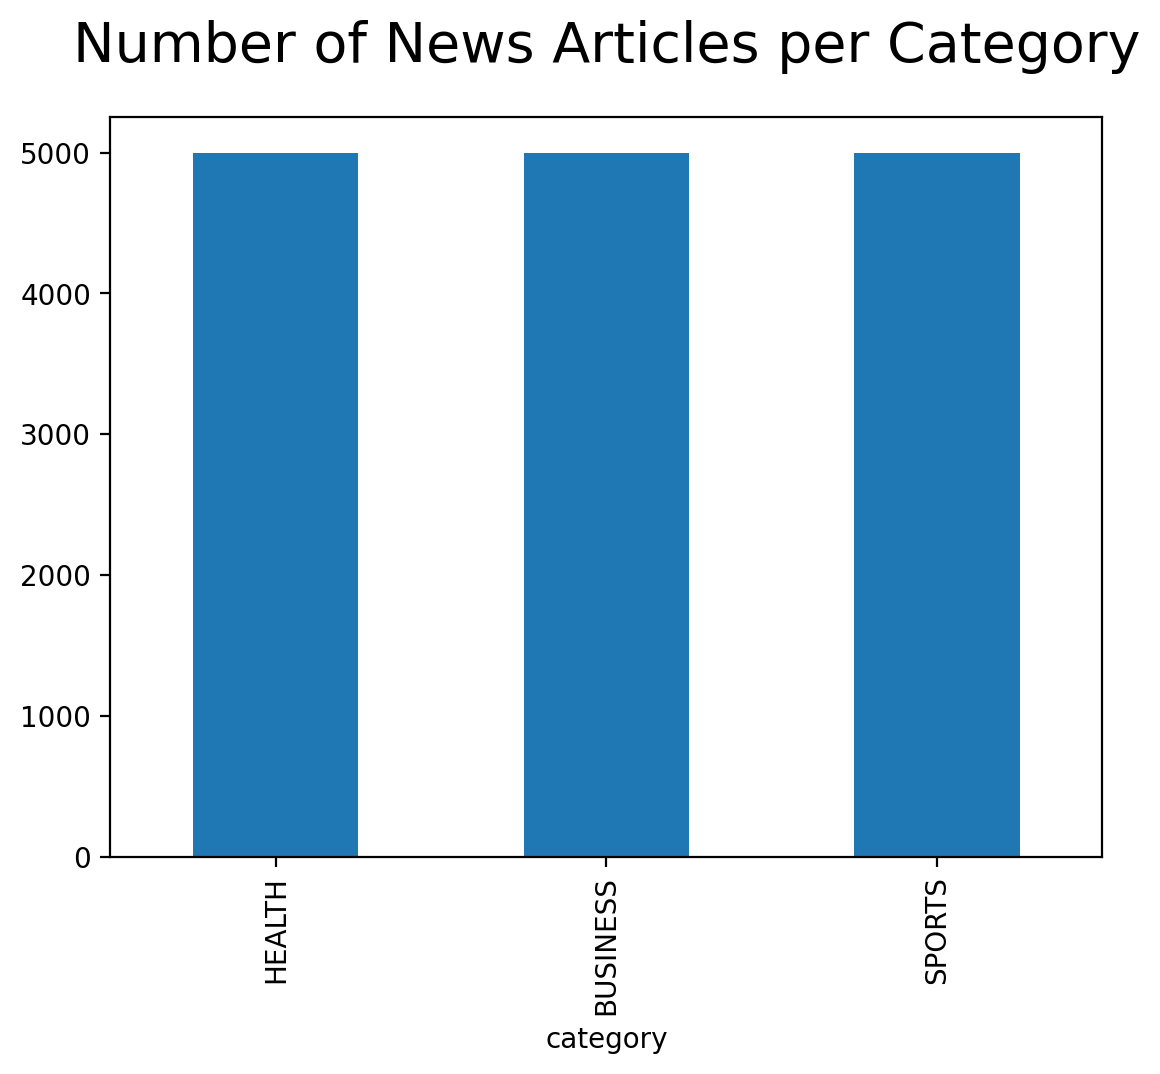

In [6]:
df['category'].value_counts().plot(kind='bar')
plt.title('Number of News Articles per Category', size=20, pad=20);

In [7]:
#Checking for missing values
df.isna().sum()

category    0
news        0
dtype: int64

### Text Preprocessing

We will now clean the text by removing special characters and punctuations.

In [8]:
def preprocess(df):
    # Remove special characters
    df['news-pro'] = df['news'].replace('\n',' ')
    df['news-pro'] = df['news-pro'].replace('\r',' ')
    
    # Remove punctuation and lowercase
    df['news-pro'] = df['news-pro'].str.lower()
    df['news-pro'] = df['news-pro'].str.translate(str.maketrans('','',string.punctuation))
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}
        return hash_tag.get(tag, wordnet.NOUN)


    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax

    df['news-pro'] = df['news-pro'].apply(lematize)

In [9]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
preprocess(df)

### Preprocessing Demonstration

**Before Pre-processing:**

In [11]:
df.iloc[0]['news']

"Resting is part of training. I've confirmed what I sort of already knew: I'm not built for running streaks. I'm built for hard workouts three to five days a week with lots of cross training, physical therapy and foam rolling. But I've also confirmed that I'm stubborn with myself."

**After Pre-processing**

In [12]:
df.iloc[0]['news-pro']

'rest part training ive confirm sort already knew im built run streak im built hard workout three five day week lot cross training physical therapy foam roll ive also confirm im stubborn '

### Train Test Split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df['news-pro'],
                                                    df['category'],
                                                    test_size=0.25,
                                                    random_state=42)

Check for acceptable category balance

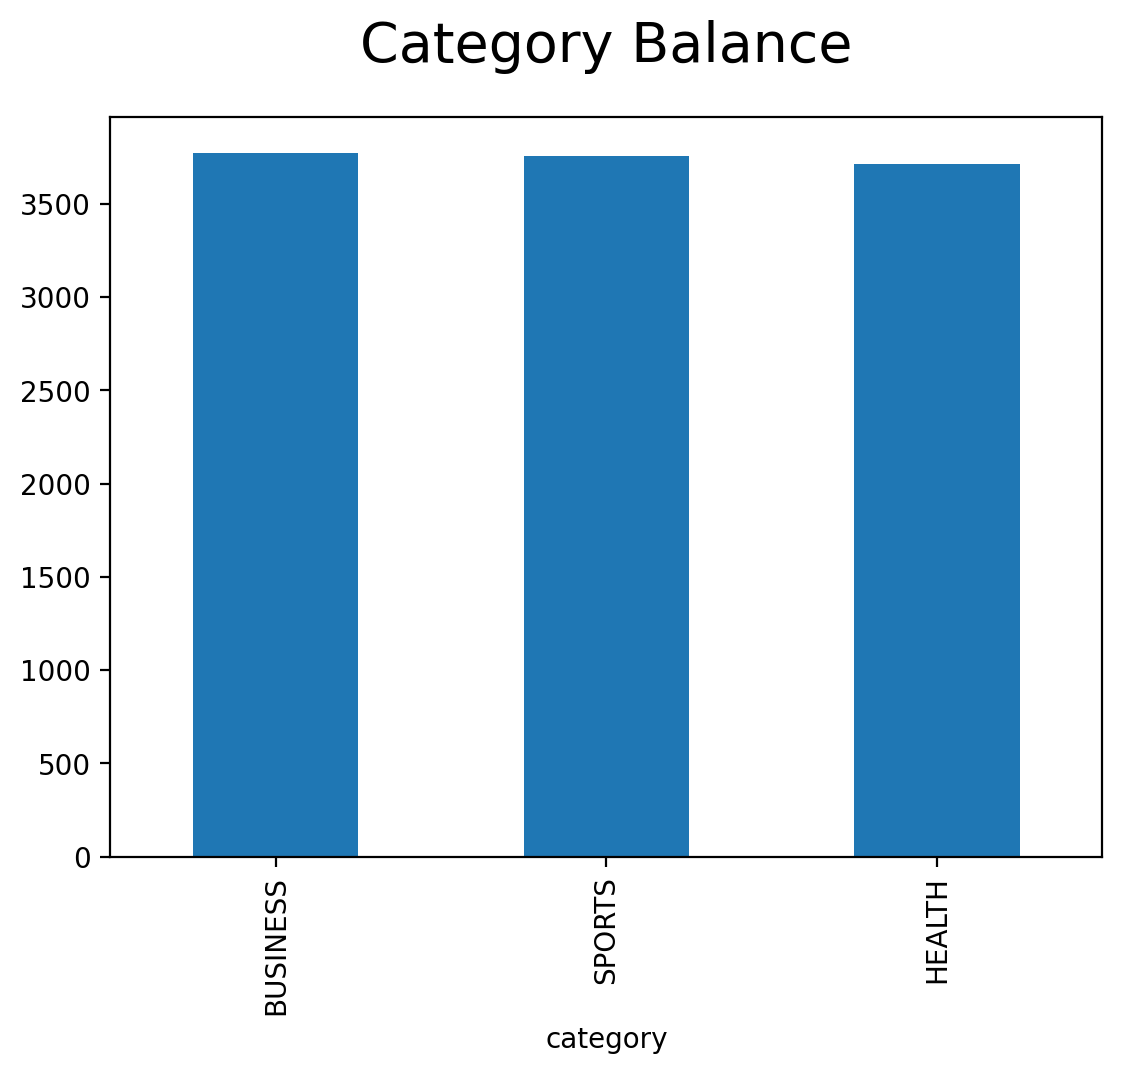

In [14]:
y_train.value_counts().plot(kind='bar')
plt.title('Category Balance', size=20, pad=20);

In [15]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(11250,) (3750,) (11250,) (3750,)


### Vectorize

In [16]:
vector = TfidfVectorizer(stop_words='english',
                        ngram_range = (1,2),
                        min_df = 3,
                        max_df = 0.7,
                        max_features = 10000)

### Model Construction

In [17]:
def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, x_train, y_train,
                            cv = KFold(shuffle = True,
                                       n_splits=3,
                                       random_state=42),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),
                            return_train_score=True, error_score='raise')
    return output

In [18]:
decisiontree = fit_model(DecisionTreeClassifier(), 'DecisionTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NaiveBayes')

dt = pd.DataFrame.from_dict(decisiontree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

In [19]:
l1 = [bc, rc, dt]
l2 = ["NaiveBayes","Ridge","DecisionTree"]

for each, tag in zip(l1,l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

In [20]:
decisiontree

{'fit_time': array([1.96161699, 1.93895864, 1.9378376 ]),
 'score_time': array([0.12617564, 0.12312675, 0.12552571]),
 'test_accuracy': array([0.76773333, 0.75973333, 0.75893333]),
 'train_accuracy': array([0.99933333, 0.99866667, 0.99946667]),
 'test_f1_weighted': array([0.76689469, 0.75757093, 0.75758639]),
 'train_f1_weighted': array([0.99933334, 0.99866665, 0.99946667]),
 'test_precision_weighted': array([0.76671715, 0.75800662, 0.7576806 ]),
 'train_precision_weighted': array([0.99933468, 0.99867191, 0.99946751]),
 'test_recall_weighted': array([0.76773333, 0.75973333, 0.75893333]),
 'train_recall_weighted': array([0.99933333, 0.99866667, 0.99946667])}

In [21]:
ridge

{'fit_time': array([0.35751057, 0.32943177, 0.32854104]),
 'score_time': array([0.11163211, 0.11151075, 0.11151695]),
 'test_accuracy': array([0.852     , 0.8528    , 0.85173333]),
 'train_accuracy': array([0.97786667, 0.98026667, 0.97746667]),
 'test_f1_weighted': array([0.85171693, 0.85245331, 0.85128898]),
 'train_f1_weighted': array([0.97785847, 0.98026395, 0.97745885]),
 'test_precision_weighted': array([0.85191804, 0.85232188, 0.85144191]),
 'train_precision_weighted': array([0.97790594, 0.98030413, 0.9775063 ]),
 'test_recall_weighted': array([0.852     , 0.8528    , 0.85173333]),
 'train_recall_weighted': array([0.97786667, 0.98026667, 0.97746667])}

In [22]:
bayes

{'fit_time': array([0.31732106, 0.30356646, 0.33156085]),
 'score_time': array([0.11674285, 0.11253142, 0.11152482]),
 'test_accuracy': array([0.81493333, 0.83333333, 0.82426667]),
 'train_accuracy': array([0.904     , 0.91093333, 0.90586667]),
 'test_f1_weighted': array([0.81586234, 0.83400543, 0.82453745]),
 'train_f1_weighted': array([0.90418075, 0.91116052, 0.90620951]),
 'test_precision_weighted': array([0.82948265, 0.83954364, 0.83334813]),
 'train_precision_weighted': array([0.9089346 , 0.91418629, 0.91011813]),
 'test_recall_weighted': array([0.81493333, 0.83333333, 0.82426667]),
 'train_recall_weighted': array([0.904     , 0.91093333, 0.90586667])}

In [23]:
relevant_measures = list(['test_accuracy', 'test_precision_weighted', 'test_recall_weighted',  'test_f1_weighted'])


dec_tree_metrics = joined_output.loc[joined_output.model == 'DecisionTree'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NaiveBayes'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

Decision Tree Metrics

In [24]:
dec_tree_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.767733,0.766717,0.767733,0.766895
1,0.759733,0.758007,0.759733,0.757571
2,0.758933,0.757681,0.758933,0.757586


Multinomial Naive Bayes Metrics

In [25]:
nb_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.814933,0.829483,0.814933,0.815862
1,0.833333,0.839544,0.833333,0.834005
2,0.824267,0.833348,0.824267,0.824537


Ridge Classifier Metrics

In [26]:
r_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.852000,0.851918,0.852000,0.851717
1,0.852800,0.852322,0.852800,0.852453
2,0.851733,0.851442,0.851733,0.851289


Average Metrics

In [27]:
metrics_ = [dec_tree_metrics, nb_metrics, r_metrics]
names_ = ['Decision Tree', 'Naive Bayes', 'Ridge Classifier']

for scores, names in zip(metrics_, names_):
    print(f'{names} Mean Metrics:')
    print(scores.mean())
    print(" ")

Decision Tree Mean Metrics:
test_accuracy              0.762133
test_precision_weighted    0.760801
test_recall_weighted       0.762133
test_f1_weighted           0.760684
dtype: float64
 
Naive Bayes Mean Metrics:
test_accuracy              0.824178
test_precision_weighted    0.834125
test_recall_weighted       0.824178
test_f1_weighted           0.824802
dtype: float64
 
Ridge Classifier Mean Metrics:
test_accuracy              0.852178
test_precision_weighted    0.851894
test_recall_weighted       0.852178
test_f1_weighted           0.851820
dtype: float64
 


### Selecting a Model

We can see from the metrics above that Ridge Classifier performs the best among three. However, we will be choosing the Multinomial Naive Bayes Classifier as the final model due to it's ability to provide probability score for each prediction.

In [28]:
x = pd.concat([x_train,
               x_test])
y = pd.concat([y_train,
               y_test])

In [29]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize',vector), ('model',best_clf)])
    return pipeline.fit(x,y)

In [30]:
classifier = create_and_fit(MultinomialNB(),x,y)

In [31]:
classifier.classes_

array(['BUSINESS', 'HEALTH', 'SPORTS'], dtype='<U8')

### Final Testing

This text is extracted through Google News from the Business Section.
The classifier should predict the text as "BUSINESS"

In [32]:
input_text = 'A 34%, three-day surge in SoftBank Group Corp. has pushed its shares to the most overbought level in more than two decades on the back of Arm Holdings Plc.’s explosive rally.'
classifier.predict_proba([input_text])

array([[0.43035041, 0.2765513 , 0.29309829]])

In [33]:
classifier.predict([input_text])[0]

'BUSINESS'

### GUI

In [36]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText


window = tk.Tk()


window.title("TEXT CLASSIFIER")
window.minsize(600,400)

text_box = ScrolledText(window)
text_box.grid(column=0, row=1, padx=5, pady=5)

def result(res, pr):
    BUSINESS = round(pr[0][0], 3)
    HEALTH = round(pr[0][1], 3)
    SPORTS = round(pr[0][2], 3)
    
    lines = [f"Health: {HEALTH}", f"Business: {BUSINESS}", f"Sports: {SPORTS}"]
    tk.messagebox.showinfo(message= f"Predicted Category: {str(res).capitalize()}" + "\n\n\n"+"\n".join(lines))

def clickMe():
    classification = tk.StringVar()
    category_,probabilities = classify_text(text_box.get("1.0",tk.END))
    result(category_, probabilities)
    

def classify_text(input_text):
    out = classifier.predict([input_text])[0]
    probs = classifier.predict_proba([input_text])
    return out,probs

label = tk.Label(window, text = "Enter Text to be classified")
label.grid(column = 0, row = 0)

btn = tk.Button(window, text="Classify", command=clickMe)
btn.grid(column=0, row=2)


window.mainloop()